In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/regression_norm/keras/default/1/model_regression_norm.keras
/kaggle/input/ogw3-augmented/X_damage_augmented.npy
/kaggle/input/ogw3-augmented/X_freq_augmented.npy
/kaggle/input/ogw3-augmented/X_signals_augmented.npy
/kaggle/input/regression_norm_500/keras/default/1/model_regression_norm_500.keras
/kaggle/input/regressionv1/keras/default/1/model_checkpoint_regression.keras


# 1.5) loading augmented data

In [2]:
import os
import matplotlib.pyplot as plt

In [3]:
%pwd


'/kaggle/working'

In [4]:
os.chdir("..")
os.chdir("input")

In [5]:
X_signals_augmented = np.load('ogw3-augmented/X_signals_augmented.npy')
X_damage_augmented = np.load('ogw3-augmented/X_damage_augmented.npy')
X_freq_augmented = np.load('ogw3-augmented/X_freq_augmented.npy')


In [6]:
print(f"X_signals shape:{X_signals_augmented.shape}")
print(f"X_signals shape:{X_damage_augmented.shape}")
print(f"X_signals shape:{X_freq_augmented.shape}")

X_signals shape:(2040, 4369, 1)
X_signals shape:(2040, 14)
X_signals shape:(2040, 12)


In [8]:
import numpy as np

def summarize_data(X, name):
    print(f"Summary for {name}:")
    print("Mean:", np.mean(X, axis=0))
    print("Variance:", np.var(X, axis=0))
    print("Min:", np.min(X, axis=0))
    print("Max:", np.max(X, axis=0))
    print("-" * 50)

summarize_data(X_signals_augmented, "X_signals_augmented")
summarize_data(X_freq_augmented, "X_freq_augmented")


Summary for X_signals_augmented:
Mean: [[-0.00808563]
 [-0.03676917]
 [ 0.00793156]
 ...
 [ 0.43494834]
 [ 0.47826858]
 [ 0.47794448]]
Variance: [[0.04756828]
 [0.05728288]
 [0.05182533]
 ...
 [0.11266843]
 [0.11778735]
 [0.1192308 ]]
Min: [[-1.]
 [-1.]
 [-1.]
 ...
 [-1.]
 [-1.]
 [-1.]]
Max: [[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
--------------------------------------------------
Summary for X_freq_augmented:
Mean: [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333]
Variance: [0.07638889 0.07638889 0.07638889 0.07638889 0.07638889 0.07638889
 0.07638889 0.07638889 0.07638889 0.07638889 0.07638889 0.07638889]
Min: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Max: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
--------------------------------------------------


In [9]:
import pandas as pd

damage_counts = pd.Series(X_damage_augmented.flatten()).value_counts()
print("Damage Condition Counts:\n", damage_counts)


Damage Condition Counts:
 0.0    26520
1.0     2040
Name: count, dtype: int64


# 2. Execution and model Training
This is where the actual execution starts

In [10]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os

In [11]:
os.chdir("..")
os.chdir("working")

In [12]:
os.chdir("..")
%pwd

'/kaggle'

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split

# ----------------------------------------------------------------------
# Step 1: Convert one-hot encoded damage labels to scalar values.
# ----------------------------------------------------------------------
# Each sample in X_damage_augmented is a one-hot vector. We convert it to the
# corresponding class index (i.e., 0 for undamaged, 1-13 for damage levels).
y_augmented = np.argmax(X_damage_augmented, axis=1).astype(np.float32)
# y_augmented now has shape (num_samples,)

In [14]:
y_augmented.min()

0.0

In [15]:
# ----------------------------------------------------------------------
# Step 2: Define the features.
# ----------------------------------------------------------------------
# For this regression task, we use the guided wave signals as the features.
# (If you wish to include frequency information as additional features, you might
# concatenate or process X_freq_augmented separately; here we assume only the signal is used.)
X_augmented = X_signals_augmented  # shape: (num_samples, 4369, 1)

In [16]:
# ----------------------------------------------------------------------
# Step 3: Split the data into training and test sets.
# ----------------------------------------------------------------------
# Here we use 80% of the data for training and 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(
    X_augmented, y_augmented, test_size=0.1, random_state=42
)


In [17]:



# ----------------------------------------------------------------------
# Step 4: Verify the shapes of the datasets.
# ----------------------------------------------------------------------
print(f"Training data shape: {X_train.shape}")  # Expected: (num_train_samples, 4369, 1)
print(f"Training labels shape: {y_train.shape}")  # Expected: (num_train_samples,)
print(f"Test data shape: {X_test.shape}")         # Expected: (num_test_samples, 4369, 1)
print(f"Test labels shape: {y_test.shape}")         # Expected: (num_test_samples,)


Training data shape: (1836, 4369, 1)
Training labels shape: (1836,)
Test data shape: (204, 4369, 1)
Test labels shape: (204,)


In [18]:
def print_label_distribution(y, set_name):
    """Print the distribution of labels in a dataset."""
    print(f"\n{set_name} label distribution:")
    print(f"- Baseline samples (0): {np.sum(y == 0)}")
    for damage_size in range(1, 14):
        print(f"- Damage size {damage_size}: {np.sum(y == damage_size)}")

In [19]:
# Print label distribution for training and test sets
print_label_distribution(y_train, "Training set")
print_label_distribution(y_test, "Test set")


Training set label distribution:
- Baseline samples (0): 433
- Damage size 1: 107
- Damage size 2: 107
- Damage size 3: 105
- Damage size 4: 106
- Damage size 5: 105
- Damage size 6: 107
- Damage size 7: 115
- Damage size 8: 109
- Damage size 9: 107
- Damage size 10: 111
- Damage size 11: 109
- Damage size 12: 111
- Damage size 13: 104

Test set label distribution:
- Baseline samples (0): 47
- Damage size 1: 13
- Damage size 2: 13
- Damage size 3: 15
- Damage size 4: 14
- Damage size 5: 15
- Damage size 6: 13
- Damage size 7: 5
- Damage size 8: 11
- Damage size 9: 13
- Damage size 10: 9
- Damage size 11: 11
- Damage size 12: 9
- Damage size 13: 16


In [20]:
# Convert input data to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [21]:
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [22]:
print("Min values after scaling:", np.min(X_train, axis=(1,2)))
print("Max values after scaling:", np.max(X_train, axis=(1,2)))

Min values after scaling: [-1.040155  -0.9812768 -1.        ... -1.        -0.9722817 -0.9399686]
Max values after scaling: [1.0318567  0.94322634 1.         ... 1.         0.9312466  1.0010613 ]


In [23]:
print("X_train dtype:", X_train.dtype)  # Should print float32
print("y_train dtype:", y_train.dtype)  # Should print float32

X_train dtype: float32
y_train dtype: float32


In [24]:
import numpy as np

# Compute the minimum and maximum values from the training targets.
y_min = np.min(y_train)
y_max = np.max(y_train)

# Normalize the training and test targets.
y_train_norm = (y_train - y_min) / (y_max - y_min)
y_test_norm = (y_test - y_min) / (y_max - y_min)


print("Before Normalizing training targets (first 5):", y_train[:5])
print("Before Normalizing test targets (first 5):", y_test[:5])

print("Normalized training targets (first 5):", y_train_norm[:5])
print("Normalized test targets (first 5):", y_test_norm[:5])


Before Normalizing training targets (first 5): [ 5.  3. 13.  1. 10.]
Before Normalizing test targets (first 5): [7. 0. 6. 1. 8.]
Normalized training targets (first 5): [0.3846154  0.23076923 1.         0.07692308 0.7692308 ]
Normalized test targets (first 5): [0.53846157 0.         0.46153846 0.07692308 0.61538464]


# 3. Model Architecture

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [26]:
tf.keras.backend.set_floatx('float32')

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [28]:
# Multi-GPU setup
strategy = tf.distribute.MirroredStrategy()

In [29]:
# Transformer Encoder block definition remains unchanged
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res


In [30]:
# Model building function adapted for regression
def build_regression_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    # Reshape the input to 3D (batch_size, 874, 1)
    x = layers.Reshape((input_shape[0], 1))(inputs)
    
    # Apply multiple Transformer Encoder blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Flatten the tensor for the MLP part
    x = layers.Flatten()(x)
    
    # MLP layers
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    
    # Output layer for regression: Predict a single value.
    # Using a sigmoid activation and scaling by 13 ensures outputs in [0, 13].
    dense = layers.Dense(1, activation="sigmoid")(x)
    outputs = layers.Lambda(lambda x: 13 * x)(dense)
    
    return keras.Model(inputs, outputs)


In [31]:
%pwd

'/kaggle'

In [32]:
from tensorflow.keras.models import load_model

In [35]:
keras.config.enable_unsafe_deserialization()
# Load the model within the strategy scope
with strategy.scope():
    model_reg = load_model('input/regression_norm_500/keras/default/1/model_regression_norm_500.keras')

In [36]:
X_train.shape

(1836, 4369, 1)

In [37]:
y_train.shape

(1836,)

In [38]:
y_train,y_test

(array([ 5.,  3., 13., ...,  0.,  4.,  6.], dtype=float32),
 array([ 7.,  0.,  6.,  1.,  8.,  4.,  0.,  4.,  0.,  1.,  4.,  9.,  9.,
        12.,  3., 13.,  5.,  5.,  2.,  9.,  0.,  0., 12.,  8.,  3.,  0.,
         0.,  4.,  0.,  1.,  3.,  0.,  7.,  5.,  5.,  9., 10., 10.,  4.,
         0.,  0.,  3.,  5., 10., 13., 12.,  7.,  2.,  0.,  0.,  0.,  0.,
         0., 11.,  6.,  6., 12.,  0.,  4.,  0.,  0.,  3.,  4.,  6.,  9.,
         0.,  6.,  8.,  5.,  0.,  6., 12.,  0.,  5.,  3., 13.,  1.,  0.,
         9., 11.,  6.,  6.,  9.,  0.,  8.,  4.,  5.,  0., 13., 12.,  1.,
         2.,  3.,  0.,  3.,  0.,  4.,  8.,  8.,  5.,  5.,  3., 12., 13.,
        13.,  5.,  0.,  6.,  0., 11., 11.,  1.,  0.,  1.,  8.,  0.,  0.,
         0., 13.,  0.,  2., 12.,  0., 11.,  6., 13.,  5., 10., 10.,  4.,
         2., 13.,  9.,  2.,  2.,  4.,  0.,  1.,  9.,  3.,  0.,  7., 11.,
         1.,  0.,  5.,  8.,  1.,  9., 10.,  5., 12.,  1.,  0.,  2.,  3.,
        13.,  5.,  2.,  0.,  2.,  4.,  4.,  0., 11.,  0., 10., 1

In [39]:
# Assume X_train has the shape (num_samples, 4369, 1)
num_samples, original_length, channels = X_train.shape

# Calculate padding length so that the length becomes divisible by 5.
pad_len = 1

# Pad along the sequence axis (axis=1) with -np.inf so that the max operation is not affected.
X_train_padded = np.pad(
    X_train,
    pad_width=((0, 0), (0, pad_len), (0, 0)),
    mode='constant',
    constant_values=-np.inf
)

# Now X_train_padded has the shape (num_samples, 4370, 1).


In [40]:
X_train_padded.shape

(1836, 4370, 1)

In [41]:

# Reshape to group every 5 consecutive elements:
# New shape will be (num_samples, 874, 5, 1)
grouped_length = X_train_padded.shape[1] // 5  # Should be 874
X_train_grouped = X_train_padded.reshape(num_samples, grouped_length, 5, channels)

# Take the max over the 5 elements for each group (axis=2)
# Resulting shape is (num_samples, 874, 1)
X_train_max = np.max(X_train_grouped, axis=2)

# Optionally, if your model expects inputs of shape (num_samples, 874),
# reshape the array from (num_samples, 874, 1) to (num_samples, 874)
X_train_final = X_train_max.reshape(num_samples, grouped_length)

# Check the resulting shape
print("Shape after max-pooling and reshaping:", X_train_final.shape)


Shape after max-pooling and reshaping: (1836, 874)


In [42]:
# Assume X_train has the shape (num_samples, 4369, 1)
num_samples, original_length, channels = X_test.shape

# Calculate padding length so that the length becomes divisible by 5.
pad_len = 1

# Pad along the sequence axis (axis=1) with -np.inf so that the max operation is not affected.
X_test_padded = np.pad(
    X_test,
    pad_width=((0, 0), (0, pad_len), (0, 0)),
    mode='constant',
    constant_values=-np.inf
)

# Now X_train_padded has the shape (num_samples, 4370, 1).

# Reshape to group every 5 consecutive elements:
# New shape will be (num_samples, 874, 5, 1)
grouped_length = X_test_padded.shape[1] // 5  # Should be 874
X_test_grouped = X_test_padded.reshape(num_samples, grouped_length, 5, channels)

# Take the max over the 5 elements for each group (axis=2)
# Resulting shape is (num_samples, 874, 1)
X_test_max = np.max(X_test_grouped, axis=2)

# Optionally, if your model expects inputs of shape (num_samples, 874),
# reshape the array from (num_samples, 874, 1) to (num_samples, 874)
X_test_final = X_test_max.reshape(num_samples, grouped_length)

# Check the resulting shape
print("Shape after max-pooling and reshaping:", X_test_final.shape)


Shape after max-pooling and reshaping: (204, 874)


In [43]:
import numpy as np

# Compute the minimum and maximum values from the training targets.
y_min = np.min(y_train)
y_max = np.max(y_train)

# Normalize the training and test targets.
y_train_norm = (y_train - y_min) / (y_max - y_min)
y_test_norm = (y_test - y_min) / (y_max - y_min)


print("Before Normalizing training targets (first 5):", y_train[:5])
print("Before Normalizing test targets (first 5):", y_test[:5])

print("Normalized training targets (first 5):", y_train_norm[:5])
print("Normalized test targets (first 5):", y_test_norm[:5])

Before Normalizing training targets (first 5): [ 5.  3. 13.  1. 10.]
Before Normalizing test targets (first 5): [7. 0. 6. 1. 8.]
Normalized training targets (first 5): [0.3846154  0.23076923 1.         0.07692308 0.7692308 ]
Normalized test targets (first 5): [0.53846157 0.         0.46153846 0.07692308 0.61538464]


In [44]:
%pwd

'/kaggle'

In [45]:
os.chdir("working")

In [46]:
os.chdir("..")
os.chdir("input")

In [47]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [48]:
# Evaluate the model using the built-in evaluation method.
# This will return the loss (MSE in our case) and MAE (as we compiled with these metrics).
loss, mae = model_reg.evaluate(X_test_final, y_test_norm, verbose=1)
print("Test Loss (MSE):", loss)
print("Test MAE:", mae)


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 411ms/step - loss: 0.0357 - mae: 0.1389
Test Loss (MSE): 0.032917570322752
Test MAE: 0.13974374532699585


In [49]:
# Make predictions on the test data.
y_pred = model_reg.predict(X_test_final)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 479ms/step


In [50]:
y_pred.min(),y_pred.max()

(0.0028377313, 1.1884644)

In [51]:
# Rescale predictions back to the original scale
y_pred_original = y_pred * (y_max - y_min) + y_min

# Rescale test targets back to the original scale for comparison
y_test_original = y_test_norm * (y_max - y_min) + y_min

In [52]:
# Compute additional regression metrics.
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae_val = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)



Additional Regression Metrics:
Mean Squared Error (MSE): 6.595402
Root Mean Squared Error (RMSE): 2.5681515
Mean Absolute Error (MAE): 1.875392
R^2 Score: 0.6629736740848552


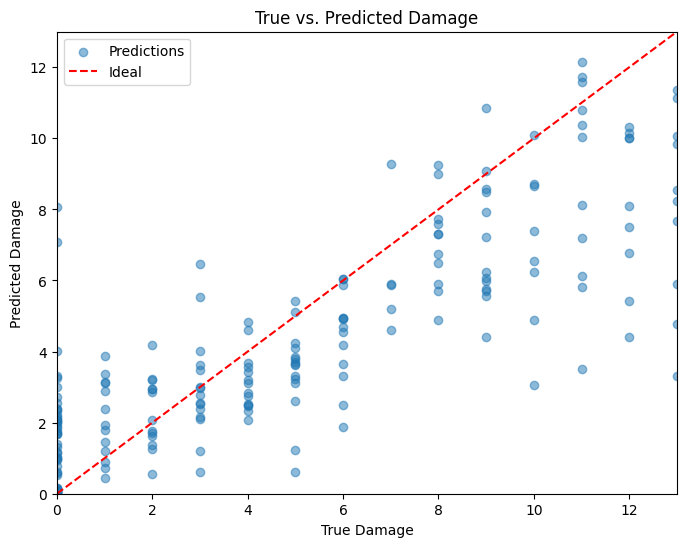

In [53]:

keras.config.enable_unsafe_deserialization()


print("\nAdditional Regression Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae_val)
print("R^2 Score:", r2)

# Create a scatter plot to compare true vs. predicted values.
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_original, alpha=0.5, label="Predictions")
plt.plot([0, 13], [0, 13], color='red', linestyle='--', label="Ideal")
plt.xlabel("True Damage")
plt.ylabel("Predicted Damage")
plt.title("True vs. Predicted Damage")
plt.xlim(0, 13)
plt.ylim(0, 13)
plt.legend()
plt.show()


In [54]:
from sklearn.metrics import explained_variance_score, median_absolute_error, mean_absolute_percentage_error
import numpy as np

# Assuming y_test contains the true values and y_pred contains your model's predictions

# Explained Variance Score
explained_variance = explained_variance_score(y_test_original, y_pred_original)
print("Explained Variance Score:", explained_variance)

# Median Absolute Error
median_ae = median_absolute_error(y_test_original, y_pred_original)
print("Median Absolute Error:", median_ae)

# You can also compute the R-squared if needed (already available via r2_score)
from sklearn.metrics import r2_score
r2 = r2_score(y_test_original, y_pred_original)
print("R² Score:", r2)


Explained Variance Score: 0.6806286573410034
Median Absolute Error: 1.391955
R² Score: 0.6629736740848552
